In [1]:
import pandas as pd
import numpy as np

In [2]:
n_tsteps =40
n_runs = 1 # only for blind test
n_prod = 5
n_inj = 3

In [3]:
def splitter(file):
    import re
    lines = file.readlines()
    B = [x for x in lines if not x.startswith('--')]
    C = " ".join(B)
    nums = []
    #                  3*4.52            4*0            0\n          4.235e-10 or 4.235E-10       5e-10 or 5E-10 
    for n in re.findall(r'\d+\*\d+\.\d+|\d+\*\d+|[0]\ |[0]\n|\d+\.\d+(?:e[+-]\d+|E[-+]\d+)?|\d+(?:e[+-]\d+|E[-+]\d+)?', C):                 
        split_by_ast = n.split("*")
        if len(split_by_ast) == 1:
            nums += [float(split_by_ast[0])]
        else:
            nums += [float(split_by_ast[1])] * int(split_by_ast[0])
    return nums

In [4]:
df_nn = pd.read_csv('C:/Users/pymnb/Downloads/VOLVE/15/FS/opTALL.csv')
df_nn_shuffled = df_nn.sample(1500)

#df_nn.info()

X = df_nn_shuffled.iloc[:,0:9].reset_index(drop=True)
Y = df_nn_shuffled.loc[:,"OPT"].reset_index(drop=True)

### Model Generation

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings; warnings.simplefilter('ignore')
import joblib

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

model = RandomForestRegressor(bootstrap=[True], max_depth=15, max_features='auto', n_estimators= 500)
model.fit(X_train, Y_train)

#joblib.dump(model, 'C:/Users/pymnb/Downloads/VOLVE/15/Well models/opt7.sav')

ypred_train = model.predict(X_train)
ypred_test = model.predict(X_test)

r2_train = r2_score(Y_train, ypred_train)
rmse_train = mean_squared_error(Y_train, ypred_train)
        
r2_test = r2_score(Y_test, ypred_test)
rmse_test = mean_squared_error(Y_test, ypred_test)

print( "R2_Training: {0:f}, RMSE_Training : {1:f}".format(r2_train, rmse_train))
print( "R2_Test: {0:f}, RMSE_Test : {1:f}".format(r2_test, rmse_test))

R2_Training: 0.999989, RMSE_Training : 38213053.573096
R2_Test: 0.999924, RMSE_Test : 259302868.001323


### Cross Validation

In [6]:
def get_score(model, X_train, X_test, Y_train, Y_test):
    model.fit(X_train, Y_train)
    return model.score(X_train, Y_train), model.score(X_test, Y_test)

In [7]:
for i in range(0,10):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import KFold      #import KFold
    import warnings; warnings.simplefilter('ignore')
    
    kf = KFold(n_splits=10)     #Define the split - into 10 folds 
    scores_rf = []
    
    for _, __ in kf.split(df_nn):
        X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=0.10)
        scores_rf.append(get_score(RandomForestRegressor(n_estimators=100, ), X_train1, X_test1, Y_train1, Y_test1))
        
    R2_train_av = np.average(np.array(scores_rf)[:,0])
    R2_test_av = np.average(np.array(scores_rf)[:,1])
    print(np.array(scores_rf))
    print("R2_train_av: "+ str(R2_train_av))
    print("R2_test_av:  "+ str(R2_test_av))
    print("*******************************")

[[0.99998977 0.99988434]
 [0.99998937 0.99995579]
 [0.99999171 0.99996599]
 [0.99999029 0.99991814]
 [0.99999042 0.99988956]
 [0.99999165 0.99991059]
 [0.99998951 0.99995721]
 [0.99999069 0.99993198]
 [0.99998962 0.99994091]
 [0.99998989 0.99995015]]
R2_train_av: 0.9999902909077042
R2_test_av:  0.9999304673952816
*******************************
[[0.9999896  0.99992964]
 [0.99999111 0.99993594]
 [0.99999064 0.99995957]
 [0.99999211 0.99995533]
 [0.99999141 0.99994658]
 [0.99998927 0.99992814]
 [0.9999901  0.99989535]
 [0.99999022 0.9999463 ]
 [0.99999057 0.99992516]
 [0.99999083 0.99994423]]
R2_train_av: 0.9999905845906513
R2_test_av:  0.999936624101356
*******************************
[[0.99999007 0.99991966]
 [0.9999919  0.99995332]
 [0.99998995 0.99995631]
 [0.99999025 0.99996381]
 [0.99999057 0.99994433]
 [0.9999912  0.99992744]
 [0.99998922 0.99993921]
 [0.99999125 0.99994602]
 [0.99999052 0.99994233]
 [0.99999114 0.999947  ]]
R2_train_av: 0.9999906059870092
R2_test_av:  0.999943943

KeyboardInterrupt: 

## CNN Model

In [9]:
X_train, X_test = np.array(X_train), np.array(X_test)
Y_train, y_test = np.array(Y_train).reshape(1200,1) , np.array(Y_test).reshape(300,1)
print(X_train.shape)
X_train_CNN = X_train.reshape(X_train.shape[0], 9, 1)
Y_train_CNN = Y_train
X_test_CNN = X_test.reshape(X_test.shape[0], 9, 1)
Y_test_CNN = Y_test
    
frac_val = 10                                # Enter the fraction of validation set to take from training set 
nv = X_train.shape[0]//frac_val

X_val = X_train[0:nv,:]
Y_val = Y_train[0:nv,:]

X_val_CNN = X_val.reshape(X_val.shape[0], 9, 1)
Y_val_CNN = Y_val
    
X_train_P = X_train[nv:X_train.shape[0], :]
Y_train_P = Y_train[nv:Y_train.shape[0], :]

X_train_P_CNN = X_train_P.reshape(X_train_P.shape[0], 9, 1)
Y_train_P_CNN = Y_train_P
        
###################################### Defining the function for CNN #########################################
    
def CNN(FS1, FS2, FS3, KS, NS1, NS2, Ep, BS, itera): #, partial_xtrain_CNN, partial_ytrain_CNN, xval_CNN, yval_CNN, xtest_CNN, ytest_CNN):
    
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Conv1D
    from tensorflow.keras.layers import Flatten
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.utils import plot_model
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score
    import matplotlib.pyplot as plt
    from numpy.random import seed
    #from tensorflow import set_random_seed
    import os
    import tensorflow as tf
    
    from timeit import default_timer as timer
    start = timer()
    #####################################################################################################
    from tensorflow.compat.v1 import ConfigProto, InteractiveSession  #stop the growing RAM for GPU
    
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.6
    sess = InteractiveSession(config=config)
    #############################################################################################################
    os.environ['PYTHONHASHSEED']=str(1)
    np.random.seed(1)
    #tf.set_random_seed(1)\
    
    for _ in range(0,itera):

        start = timer()

############################################### Model Built Up ######################################################

        model = Sequential()
        model.add(Conv1D(FS1, KS, activation='relu', input_shape=(9,1)))
        model.add(Conv1D(FS2, KS, activation='relu', input_shape=(9,1)))
        model.add(Conv1D(FS3, KS, activation='relu', input_shape=(9,1)))
        model.add(Flatten())
        model.add(Dense(NS1, activation='relu'))
        model.add(Dense(NS2, activation='relu'))
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
        model.summary()
        
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

        history = model.fit(X_train_P_CNN, Y_train_P_CNN, epochs=Ep, batch_size=BS, verbose=0,\
        validation_data=(X_val_CNN, Y_val_CNN), callbacks=[es])
            
        #model.save('C:/Users/pymnb/Downloads/WAG Case/18/CNN models/CNN_model_SO'+str(step)+'.h5')
        #model.save('C:/Users/pymnb/Downloads/WAG Case/18/CNN models/CNN_model_P'+str(step)+'.h5')
            
        ypred_train = model.predict(X_train_P_CNN)
        ypred_test = model.predict(X_test_CNN)

        r2_train = r2_score(Y_train_P_CNN, ypred_train)
        rmse_train = mean_squared_error(Y_train_P_CNN, ypred_train)
        
        r2_test = r2_score(Y_test_CNN, ypred_test)
        rmse_test = mean_squared_error(Y_test_CNN, ypred_test)

        print( "R2_Training: {0:f}, RMSE_Training : {1:f}".format(r2_train, rmse_train))
        print( "R2_Test: {0:f}, RMSE_Test : {1:f}".format(r2_test, rmse_test))

################################################### plotting #########################################################

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['training loss', 'validation loss'], loc='upper left')
        plt.show()
        end = timer()
        print("Run Time: "+str((end - start)//60)+" min")
        sess.close()
    ##############################################################################################################3
    
#CNN(FS1,  FS2,  FS3,  KS,  NS1,  NS2,  Ep,   BS,  itera)    
CNN(100,   100,  100,  3,   100,  100,  400,  50,    1)

(1200, 9)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 7, 100)            400       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5, 100)            30100     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3, 100)            30100     
_________________________________________________________________
flatten (Flatten)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               30100     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)      

KeyboardInterrupt: 

## MLP model

In [92]:
X_train, X_test = np.array(X_train), np.array(X_test)
Y_train, y_test = np.array(Y_train).reshape(1200,1) , np.array(Y_test).reshape(300,1)

frac_val = 10                                # Enter the fraction of validation set to take from training set 
nv = X_train.shape[0]//frac_val

X_val = X_train[0:nv,:]
Y_val = Y_train[0:nv,:]

X_train_P = X_train[nv:X_train.shape[0], :]
Y_train_P = Y_train[nv:Y_train.shape[0], :]

###################################### Defining the function for CNN ########################################
    
def MLP(NS1, NS2, Ep, BS, itera): #, partial_xtrain_CNN, partial_ytrain_CNN, xval_CNN, yval_CNN, xtest_CNN, ytest_CN
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Flatten
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.utils import plot_model
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score
    import matplotlib.pyplot as plt
    from numpy.random import seed

    import os
    import tensorflow as tf
    
    from timeit import default_timer as timer
    start = timer()
    #####################################################################################################
    from tensorflow.compat.v1 import ConfigProto, InteractiveSession  #stop the growing RAM for GPU
    
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.6
    sess = InteractiveSession(config=config)
    #############################################################################################################
    os.environ['PYTHONHASHSEED']=str(1)
    np.random.seed(1)
        
    for _ in range(0,itera):
    
        start = timer()

############################################### Model Built Up ######################################################

        model = Sequential()
        model.add(Dense(NS1, activation='relu', input_shape = (7, )))
        model.add(Dense(NS2, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
        model.summary()
            
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    
        history = model.fit(X_train_P, Y_train_P, epochs=Ep, batch_size=BS, verbose=0,\
        validation_data=(X_val, Y_val), callbacks=[es])
            
        #model.save('/workspace/myfiles/saves/SO/model_SO'+str(step)+'.h5')
        #model.save('/workspace/myfiles/saves/P/model_P'+str(step)+'.h5')
            
        ypred_train = model.predict(X_train_P)
        ypred_test = model.predict(X_test)
    
        r2_train = r2_score(Y_train_P, ypred_train)
        rmse_train = mean_squared_error(Y_train_P, ypred_train)
            
        r2_test = r2_score(Y_test, ypred_test)
        rmse_test = mean_squared_error(Y_test, ypred_test)
    
        print( "R2_Training: {0:f}, RMSE_Training : {1:f}".format(r2_train, rmse_train))
        print( "R2_Test: {0:f}, RMSE_Test : {1:f}".format(r2_test, rmse_test))

################################################### plotting #########################################################

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['training loss', 'validation loss'], loc='upper left')
        plt.show()

        end = timer()
        print("Run Time: "+str((end - start)//60)+" min")
        sess.close()
##############################################################################################################3
    
    
MLP(100,  100, 200, 1, 1)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 100)               800       
_________________________________________________________________
dense_46 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 101       
Total params: 11,001
Trainable params: 11,001
Non-trainable params: 0
_________________________________________________________________


ValueError: in user code:

    C:\Users\pymnb\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\pymnb\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\pymnb\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\pymnb\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\pymnb\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\pymnb\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\pymnb\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\pymnb\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\pymnb\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_15 is incompatible with the layer: expected axis -1 of input shape to have value 7 but received input with shape (1, 61)


### Test on Blind Test

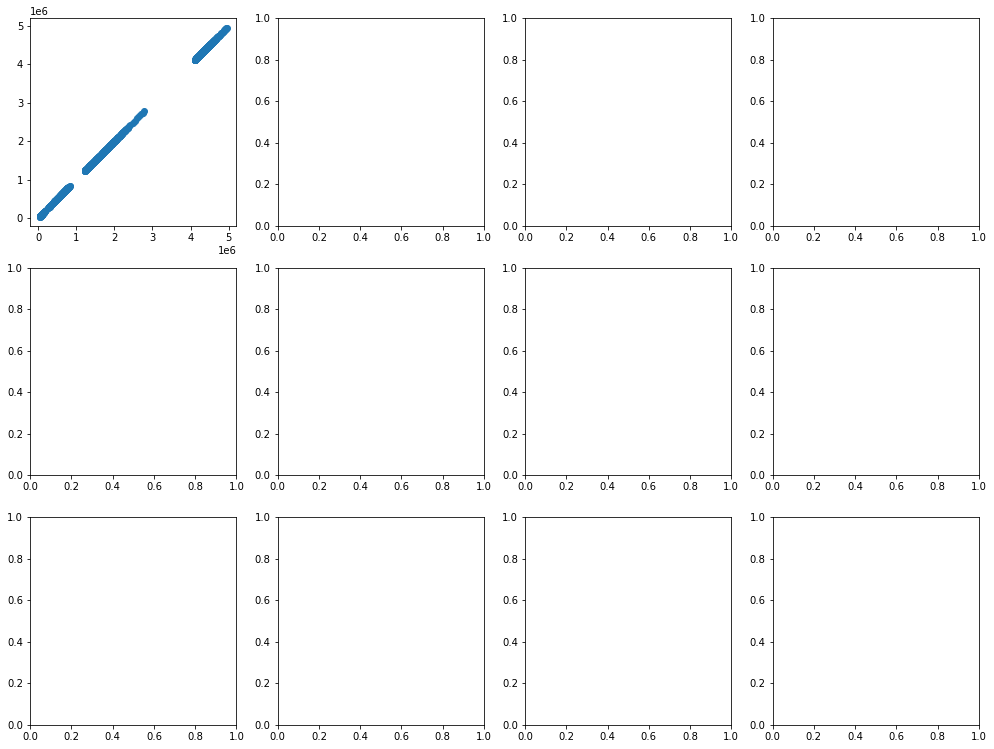

In [11]:
import matplotlib.pyplot as plt

loaded_model = joblib.load('C:/Users/pymnb/Downloads/WAG Case/18/Well models/opt.sav')
result = loaded_model.predict(X_test.iloc[1:2])
fig, ax = plt.subplots(3,4, figsize=(17,13))

ax[0,0].scatter(x = df_nn['OPT'], y = df_nn['OPT'])
#plt.xlabel("Living Area Above Ground")
#plt.ylabel("House Price")

plt.show()